### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [6]:
!nvidia-smi

Fri Jan  3 08:46:01 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [7]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [8]:
%pip install "ultralytics>=8.3.0" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 34.0/112.6 GB disk)


## Inference with model pre-trained on COCO dataset

### CLI

**NOTE:** CLI requires no customization or Python code. You can simply run all tasks from the terminal with the yolo command.

In [9]:
!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

Found https://media.roboflow.com/notebooks/examples/dog.jpeg locally at dog.jpeg
image 1/1 /content/dog.jpeg: 640x384 2 persons, 1 car, 1 dog, 1 handbag, 50.1ms
Speed: 2.9ms preprocess, 50.1ms inference, 578.7ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/detect/predict4
💡 Learn more at https://docs.ultralytics.com/modes/predict


**NOTE:** Result annotated image got saved in `{HOME}/runs/detect/predict/`. Let's display it.

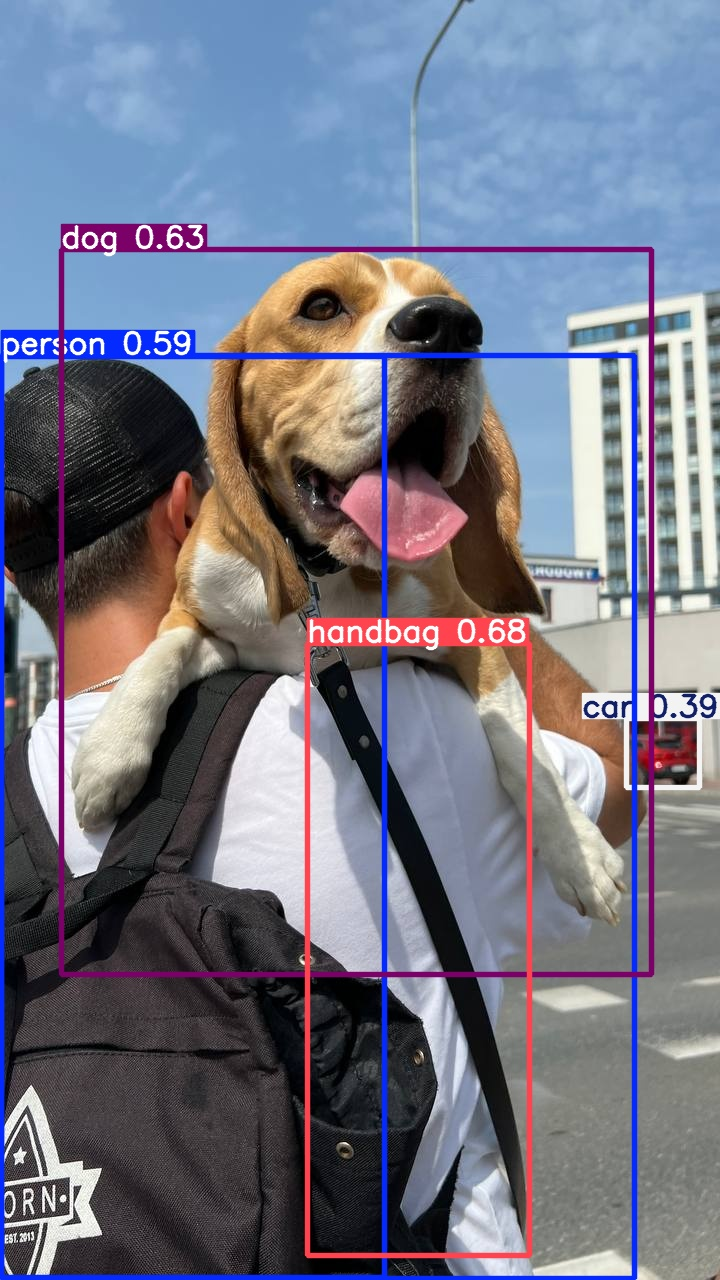

In [10]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/predict4/dog.jpg', width=600)

## Fine-tune YOLO11 on custom dataset

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/liangdianzhong/-qvdww) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

In [17]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="11f6PR14WRvZcYXw9OeX")
project = rf.workspace("lyn15").project("ai_grocify")
version = project.version(3)
dataset = version.download("yolov11")
                

mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets
loading Roboflow workspace...
loading Roboflow project...


## Custom Training

In [18]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11n.pt data={dataset.location}/data.yaml epochs=20 imgsz=640 plots=True

/content
Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/datasets/Ingredients-2/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, s

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [19]:
!ls {HOME}/runs/detect/train4/

args.yaml					     R_curve.png	  val_batch0_labels.jpg
confusion_matrix_normalized.png			     results.csv	  val_batch0_pred.jpg
confusion_matrix.png				     results.png	  val_batch1_labels.jpg
events.out.tfevents.1735894095.89c3322eb686.15773.0  train_batch0.jpg	  val_batch1_pred.jpg
F1_curve.png					     train_batch1400.jpg  val_batch2_labels.jpg
labels_correlogram.jpg				     train_batch1401.jpg  val_batch2_pred.jpg
labels.jpg					     train_batch1402.jpg  weights
P_curve.png					     train_batch1.jpg
PR_curve.png					     train_batch2.jpg


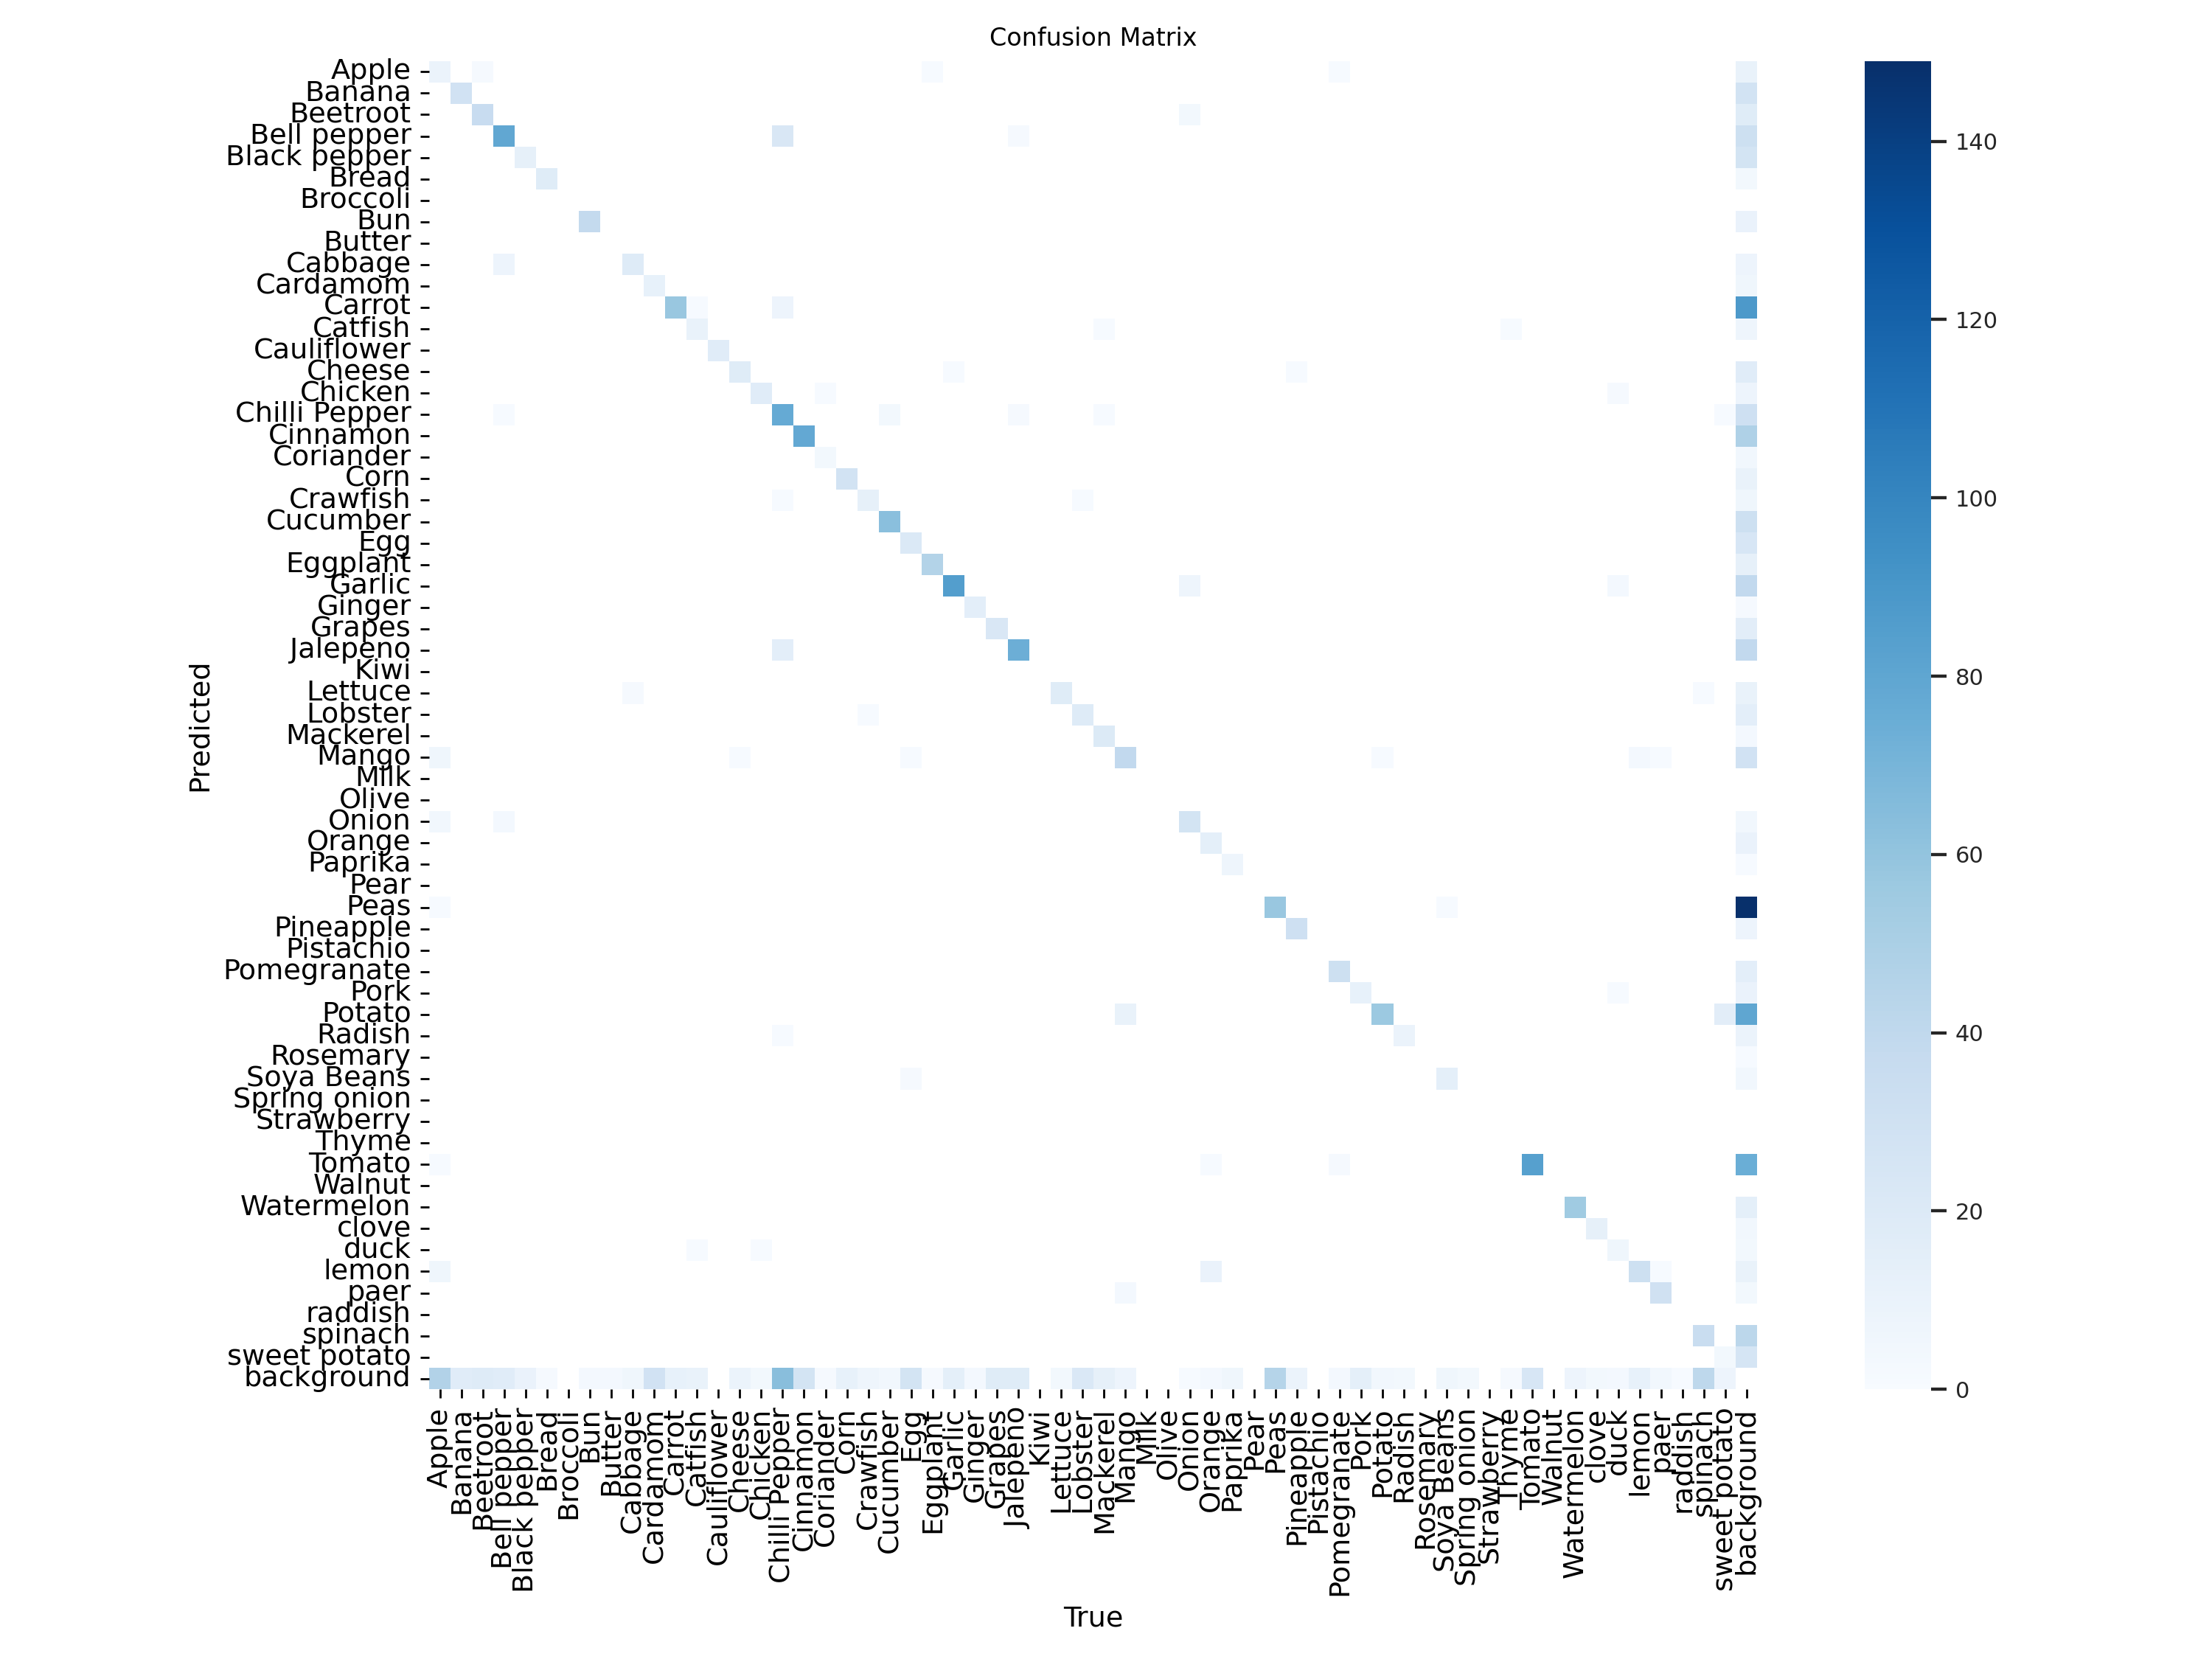

In [20]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train4/confusion_matrix.png', width=600)

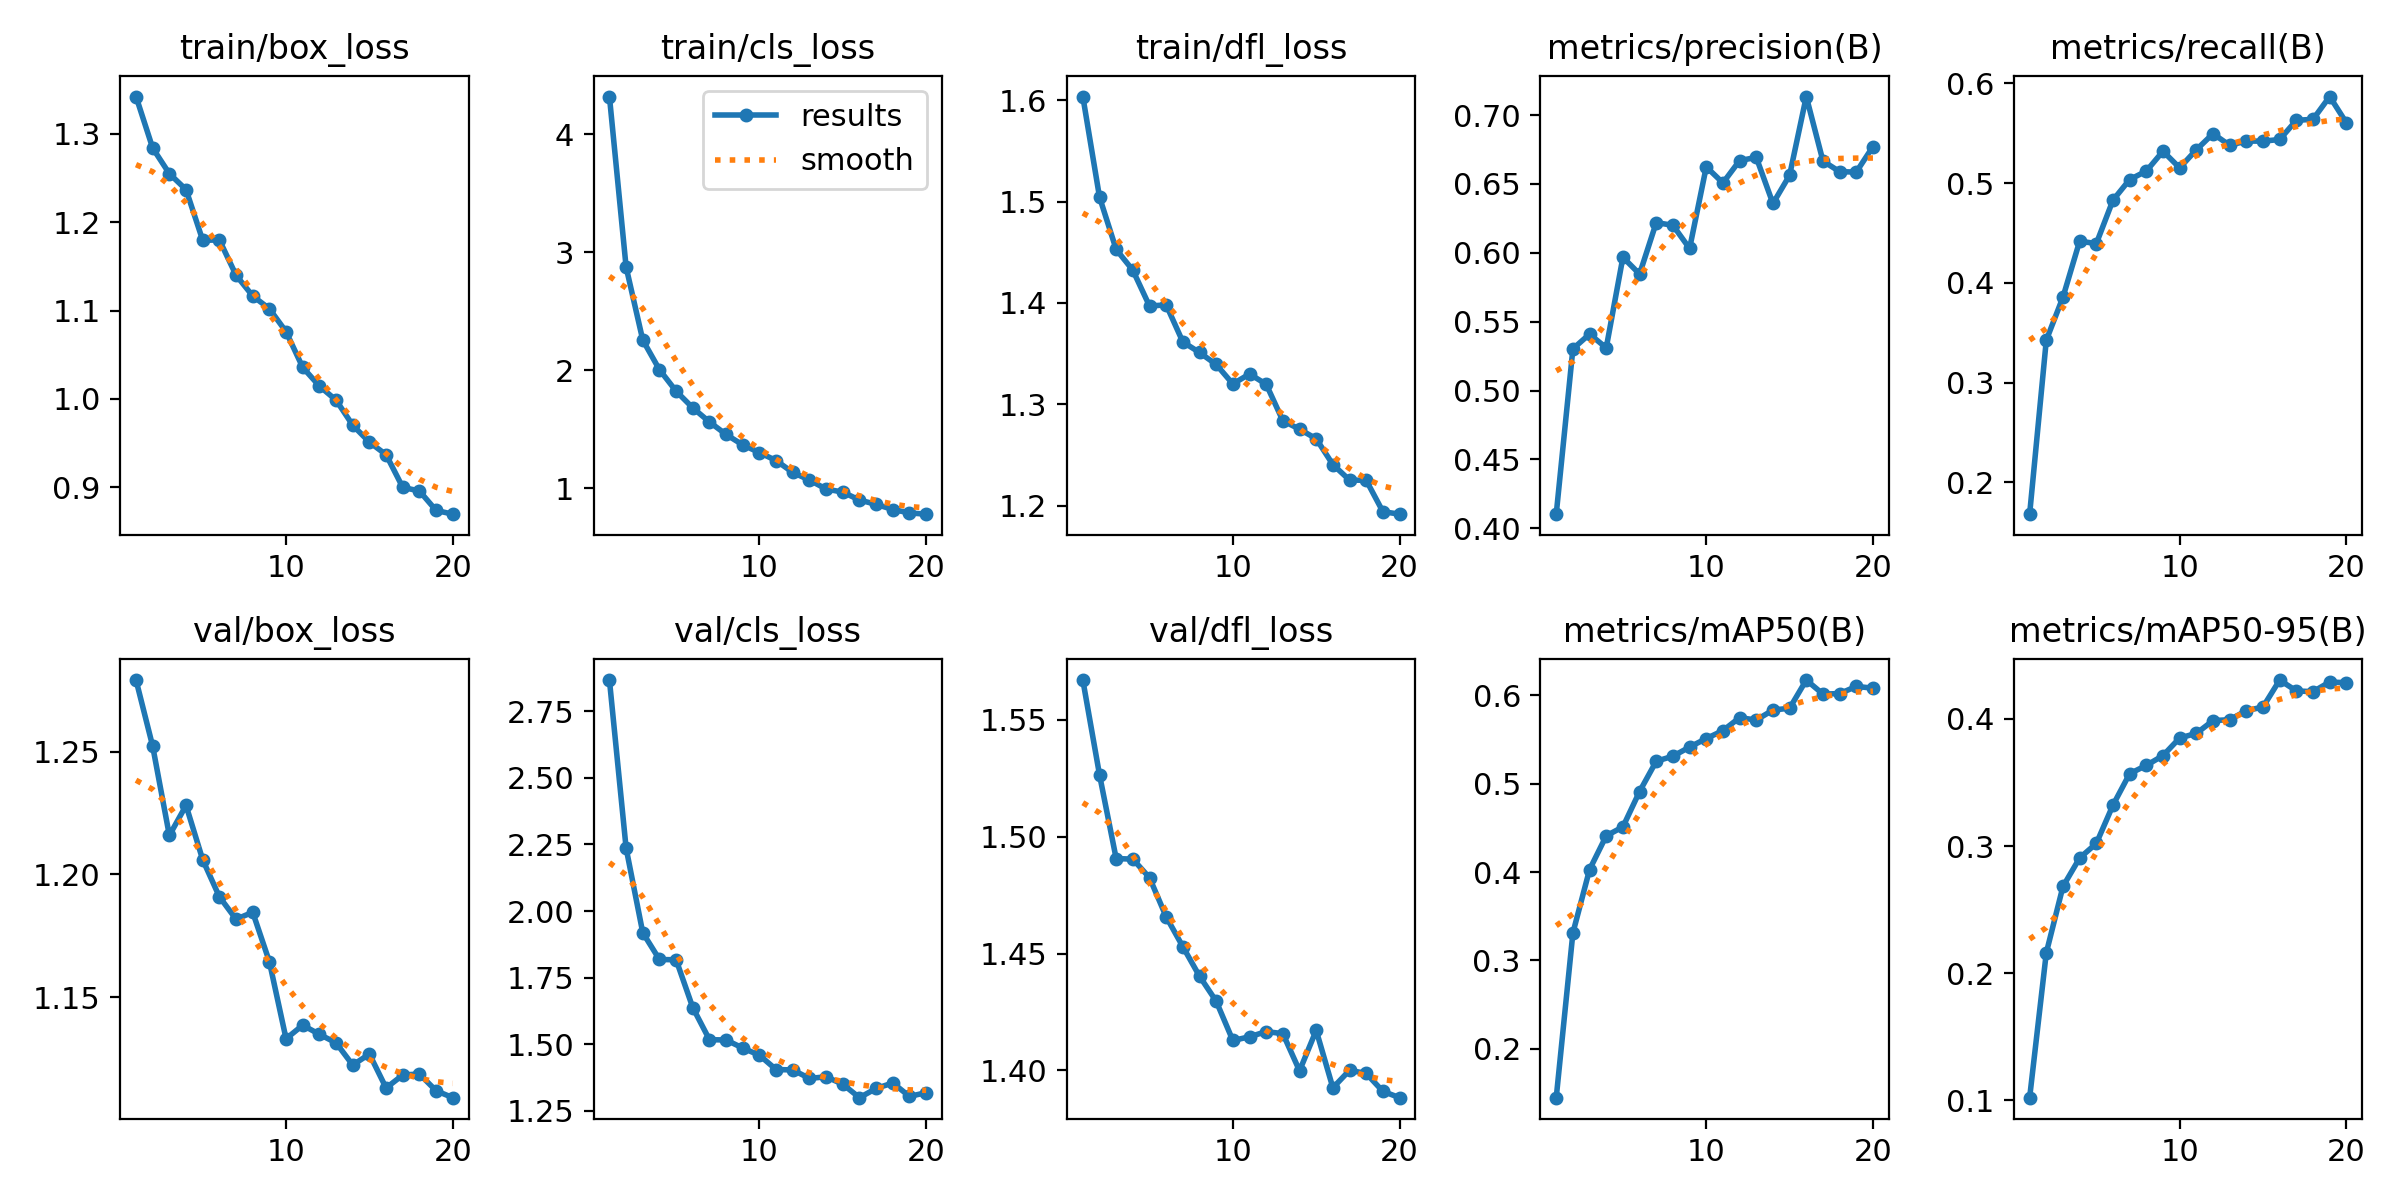

In [21]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train4/results.png', width=600)

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train4/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [23]:
!yolo task=detect mode=val model={HOME}/runs/detect/train4/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,436,407 parameters, 0 gradients, 21.4 GFLOPs
val: Scanning /content/datasets/Ingredients-2/valid/labels.cache... 637 images, 12 backgrounds, 0 corrupt: 100% 637/637 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/datasets/Ingredients-2/valid/images/Image_31_jpg.rf.df7d2b422bb6f1ff086938b059e144f9.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/datasets/Ingredients-2/valid/images/cinnamon-1-_jpg.rf.f8ded3a2580b070bdc3181719eaf8651.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/datasets/Ingredients-2/valid/images/tmp_yp12oV_47ce79a0a011adf5_GettyImages-1536235481_jpg.rf.01994b64c6240e69780d3934ad4b5d5e.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/datasets/Ingredients-2/valid/images/what-is-cinnamon-4x3-c5c5736114e74d75a56fe2039e2c1437_jpg.rf.949e02a65311ea868a35e55004d90c91.jpg: 1 duplicate labels removed
WARNING ⚠️ Box and segment counts shoul

## Inference with custom model

In [24]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train4/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,436,407 parameters, 0 gradients, 21.4 GFLOPs

image 1/317 /content/datasets/Ingredients-2/test/images/1000_F_218030921_YpdJ0eInLefviJy3jYrNd2IiJwFq4BwS_jpg.rf.f3f0cb56f4d91f93e0dd9a13c33f637b.jpg: 448x640 1 Lobster, 48.7ms
image 2/317 /content/datasets/Ingredients-2/test/images/1000_F_533541994_fghnGqtJgr8Xv07s8Zc8xGR7Qbf2CQmU_jpg.rf.ba2d9e989985f1e2d30a57a3fae754a4.jpg: 448x640 1 Black pepper, 2 Catfishs, 1 Coriander, 2 Rosemarys, 1 lemon, 12.3ms
image 3/317 /content/datasets/Ingredients-2/test/images/100322799-lobsters-for-sale-on-ice-at-market_jpg.rf.b4141a7a4b8931b06e45858bdba105a8.jpg: 448x640 8 Lobsters, 12.4ms
image 4/317 /content/datasets/Ingredients-2/test/images/1200px-Sesame_seed_hamburger_buns_jpg.rf.767c27792523f256e69bb778c5083d12.jpg: 448x640 4 Buns, 1 Potato, 12.2ms
image 5/317 /content/datasets/Ingredients-2/test/images/20230630_124424-scaled_jpg.rf.

**NOTE:** Let's take a look at few results.

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/detect/predict5/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:100]:
    display(IPyImage(filename=img, width=600))
    print("\n")

## Deploy model on Roboflow

Once you have finished training your YOLOv11 model, you’ll have a set of trained weights ready for use. These weights will be in the `/runs/detect/train/weights/best.pt` folder of your project. You can upload your model weights to Roboflow Deploy to use your trained weights on our infinitely scalable infrastructure.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) now supports uploading YOLOv11 weights.

In [30]:
project.version(3).deploy(model_type="yolov11", model_path=f"{HOME}/runs/detect/train4")

View the status of your deployment at: https://app.roboflow.com/lyn15/ingredients-ctbug-jczvq/3
Share your model with the world at: https://universe.roboflow.com/lyn15/ingredients-ctbug-jczvq/model/3


In [31]:
!pip install inference

In [ ]:
import os, random, cv2
import supervision as sv
import IPython
import inference

model_id = project.id.split("/")[1] + "/" + dataset.version
model = inference.get_model(model_id, userdata.get('ROBOFLOW_API_KEY'))

# Location of test set images
test_set_loc = dataset.location + "/test/images/"
test_images = os.listdir(test_set_loc)

# Run inference on 4 random test images, or fewer if fewer images are available
for img_name in random.sample(test_images, min(4, len(test_images))):
    print("Running inference on " + img_name)

    # Load image
    image = cv2.imread(os.path.join(test_set_loc, img_name))

    # Perform inference
    results = model.infer(image, confidence=0.4, overlap=30)[0]
    detections = sv.Detections.from_inference(results)

    # Annotate boxes and labels
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    annotated_image = box_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Display annotated image
    _, ret = cv2.imencode('.jpg', annotated_image)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)


In [ ]:
%pip install "ultralytics>=8.3.0"

In [ ]:
import roboflow

rf = roboflow.Roboflow(api_key='11f6PR14WRvZcYXw9OeX')
project = rf.workspace().project('ingredients-ctbug-jczvq')

#can specify weights_filename, default is "weights/best.pt"
version = project.version(2)
#version.deploy("model-type", "path/to/training/results/", "weights_filename")

#example2 - directory path is "training1/weights/best.pt" for yolov8 model
version.deploy("yolov11", "/content/runs/detect/train2")
